In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[39]:

import datetime as dt
import itertools as it 
import os
import sys

import pandas as pd

import joblib

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
from sklearn.datasets import make_blobs
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVC
from sklearn.model_selection import (
    #KFold, 
    StratifiedKFold, 
    train_test_split)

sys.path.insert(0, os.path.abspath(".."))

from libs.container import Container
import dataset

BEST_PARAMS = joblib.load("../results/hp_selection.pkl.bz2")


In [2]:
blobs = {
    "diagonal": pd.read_pickle("noises/diag.pkl"),
    "left-right": pd.read_pickle("noises/lr.pkl"),
    "up-down": pd.read_pickle("noises/ud.pkl"),
    "mix": pd.read_pickle("noises/mixed.pkl"),
}

FEATURES = [c for c in blobs["mix"].columns if c.lower().startswith("x")]
print(FEATURES)

def load_blobs():
    for name, df in blobs.items():
        df = df.copy()
        df[FEATURES] = StandardScaler().fit_transform(df[FEATURES].values)
        df["cls"] = df["y"]
        del df["y"]
        yield name, df

['x0', 'x1', 'xn0', 'xn1', 'xn2', 'xn3', 'xn4', 'xn5', 'xn6', 'xn7', 'xn8', 'xn9', 'xn10', 'xn11', 'xn12', 'xn13', 'xn14', 'xn15', 'xn16', 'xn17', 'xn18', 'xn19', 'xn20', 'xn21', 'xn22', 'xn23', 'xn24', 'xn25', 'xn26', 'xn27', 'xn28', 'xn29']


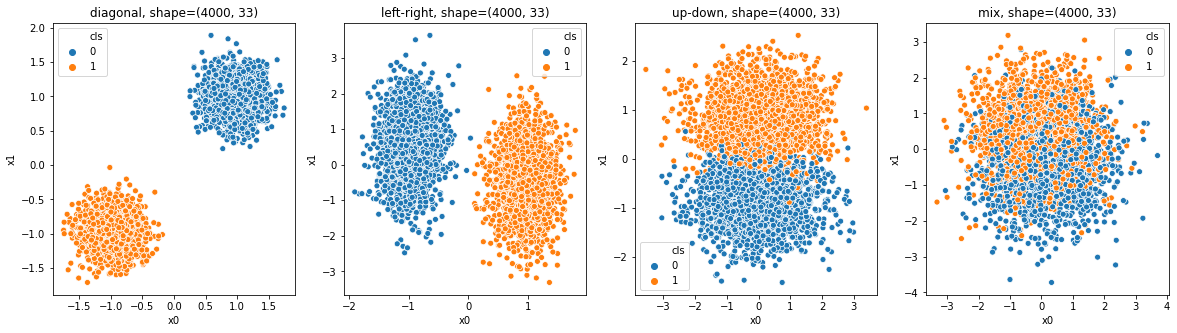

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = iter(it.chain(axes))
for n, df in load_blobs():
    ax = next(axes)
    sns.scatterplot(ax=ax, data=df, x="x0", y="x1", hue="cls")
    ax.set_title(f"{n}, shape={df.shape}")

In [4]:

def _run(cache_path, clf_class, **best_params):
    
    if os.path.exists(cache_path):
        print("Cached")
        return joblib.load(cache_path)    

    cpu = joblib.cpu_count()


    # comentado por que no se usa
#     names = ["b261", "b277", "b278", "b360"]
#     combs = list(it.combinations(names, 2))
#     print(combs)

    #_, sdata, _ = dataset.load_blobs()

    res = {}
    
    # cambiamos este for
    # for t0, t1 in combs: 
    
    for name, df in load_blobs():
        print(dt.datetime.now())

#         df = pd.concat([sdata[t0], sdata[t1]])

#         cls = {name: idx for idx, name in enumerate(df.tile.unique())}
        print(df.cls.unique())
#         df["cls"] = df.tile.apply(cls.get)

        X = df[FEATURES].values
        y = df.cls.values

        clf = clf_class(**best_params)
        sel = RFECV(clf, n_jobs=-1, cv=5)

        print("fit")
        sel.fit(X, y)

        print("storing")
        res[name] = sel

        print("-----------------------------")

    joblib.dump(res, cache_path, compress=3)    
    return res



def run_svm_linear():
    cache_path = "../results/rfecv_blobs.pkl.bz2"    
    svcl_params = BEST_PARAMS["svc_linear"].best_params_
    print(svcl_params)
    return _run(cache_path=cache_path, clf_class=SVC, **svcl_params)

In [5]:
res = run_svm_linear()

{'C': 100, 'kernel': 'linear', 'probability': True}
Cached


In [6]:
for k in blobs.keys():
    print(k, np.array(FEATURES)[res[k].support_])

diagonal ['x1']
left-right ['x0']
up-down ['x0' 'x1' 'xn12' 'xn26']
mix ['x0' 'x1' 'xn0' 'xn2' 'xn3' 'xn4' 'xn5' 'xn8' 'xn17' 'xn23' 'xn24' 'xn27']


## Analisis

In [7]:
sel = res

In [8]:
count = {}
resume = {"Feature": FEATURES}
for key, clf in sel.items():
    count[key] = clf.support_.sum()
    
    print(f"[{key}] Selected Features: ", clf.support_.sum())
    resume.update({
        f"{key} Selected": clf.support_, 
        f"{key} Ranking": clf.ranking_, 
        f"{key} Score": clf.grid_scores_})
resume.keys()

rdf = pd.DataFrame(resume)
rdf = rdf.reset_index(drop=True)

rdf["Mean Score"] = rdf[rdf.columns[rdf.columns.str.endswith(" Score")]].mean(axis=1)
rdf["Selected N"] = rdf[rdf.columns[rdf.columns.str.endswith(" Selected")]].sum(axis=1)

[diagonal] Selected Features:  1
[left-right] Selected Features:  1
[up-down] Selected Features:  4
[mix] Selected Features:  12


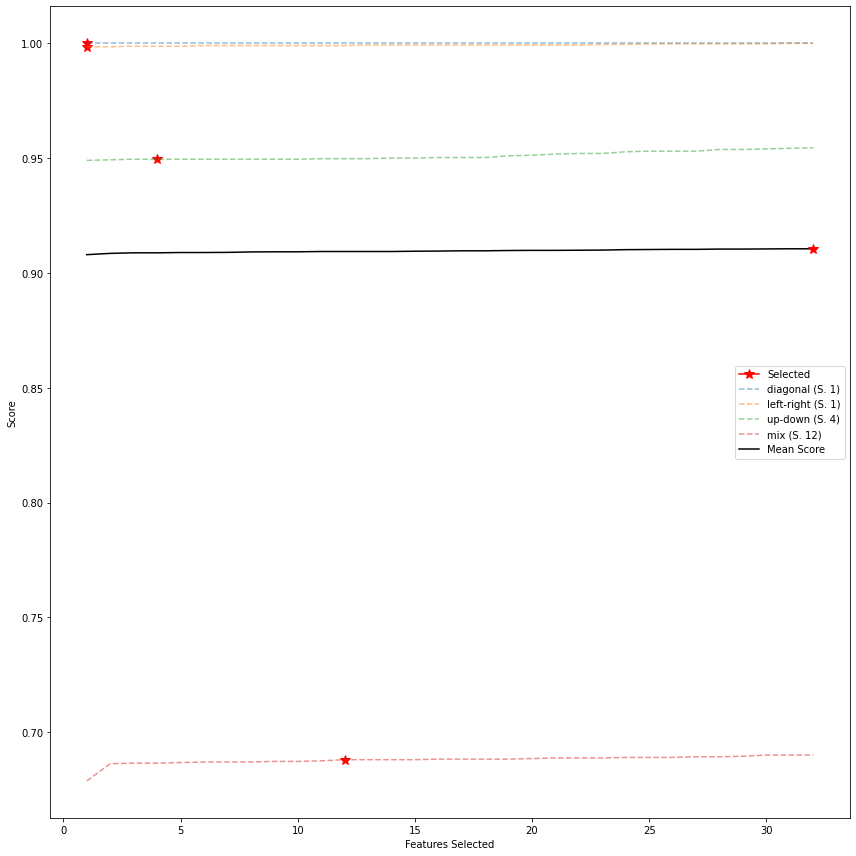

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))

selected_label = "Selected"
for key in sorted(sel.keys(), key=count.get):
    cnt = count[key]
#     if cnt < 10:
#         continue
    
#     key = "-".join(key)
    scores = sorted(rdf[f"{key} Score"].values)
    selected = rdf[f"{key} Selected"].sum()
    
    label = f"{key} (S. {selected})"
    
    ax.plot(selected, scores[selected], color="r", marker="*", markersize=10, label=selected_label)
    ax.plot(range(1, len(scores) + 1), scores, alpha=.5, ls="--", label=label)
    
    selected_label = "_no_label_"
    

label = f"Mean Score"
mfeats = range(1, len(scores) + 1)
mscores = sorted(rdf["Mean Score"].values)
plt.plot(mfeats, mscores, label=label, color="k")

amax = np.argmax(mscores)
ax.plot(mfeats[amax], mscores[amax], color="r", marker="*", markersize=10, label=selected_label)
    
ax.set_xlabel("Features Selected")
ax.set_ylabel("Score")

# plt.plot(range(1, len(sel.grid_scores_) + 1), sel.grid_scores_)
# plt.axvline(selected, c="r", alpha=0.5, ls="--", label=f"Features óptimos ({selected})")
plt.legend()
plt.tight_layout()
# plt.savefig("plots/rfe.pdf")
plt.show()

In [10]:
colors = {
    6: "#ccebc5",
    5: "#ccebd9",
    4: "#b3cde3",
    3: "#decbe4",
    2: "#ffffcc",
    1: "#fbb4ae",   
}

def color_selected(row):
    color = colors.get(row["Selected N"])
    if color is not None:
        return pd.Series(f'background-color: {color}; color: black', row.index)
    
    return pd.Series('', row.index)

resume = rdf[rdf.columns[(
    rdf.columns.str.endswith(" Selected") | 
    rdf.columns.str.startswith("Feature") |
    rdf.columns.str.startswith("Selected N"))]
].sort_values("Selected N", ascending=False).reset_index(drop=True)

html = resume.style.apply(color_selected, axis=1)
html

,Feature,diagonal Selected,left-right Selected,up-down Selected,mix Selected,Selected N
0,x0,False,True,True,True,3
1,x1,True,False,True,True,3
2,xn27,False,False,False,True,1
3,xn12,False,False,True,False,1
4,xn23,False,False,False,True,1
5,xn24,False,False,False,True,1
6,xn26,False,False,True,False,1
7,xn8,False,False,False,True,1
8,xn5,False,False,False,True,1
9,xn4,False,False,False,True,1


In [11]:
rfe_ensemble3 = resume[resume["Selected N"] >= 3].Feature.values

In [12]:
def execute_kfold(*, clf_name, clasificator, sample,  X_columns, y_column, nfolds):
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = sample[X_columns].values
    y = sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = sklearn.clone(clasificator)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    print(metrics.classification_report(y_tests, predictions))
    print("-" * 80)
    
    result = {
        "clf_name": clf_name,
        "nfolds": nfolds,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)}    
    return result

In [13]:
sdata = dict(load_blobs())

BEST_PARAMS = joblib.load("../results/hp_selection.pkl.bz2") 
svcl_params = BEST_PARAMS["svc_linear"].best_params_
svcl_params

{'C': 100, 'kernel': 'linear', 'probability': True}

In [14]:
def split_feats(rdf, key):
    key = f"{key} Selected"
    df = rdf[["Feature", key]]
    
    all_feats = df["Feature"].values
    selected = df[df[key] == True]["Feature"].values
    no_selected = df[df[key] == False]["Feature"].values
    
    return all_feats, selected, no_selected

In [15]:
split_feats(rdf, "diagonal")

(array(['x0', 'x1', 'xn0', 'xn1', 'xn2', 'xn3', 'xn4', 'xn5', 'xn6', 'xn7',
        'xn8', 'xn9', 'xn10', 'xn11', 'xn12', 'xn13', 'xn14', 'xn15',
        'xn16', 'xn17', 'xn18', 'xn19', 'xn20', 'xn21', 'xn22', 'xn23',
        'xn24', 'xn25', 'xn26', 'xn27', 'xn28', 'xn29'], dtype=object),
 array(['x1'], dtype=object),
 array(['x0', 'xn0', 'xn1', 'xn2', 'xn3', 'xn4', 'xn5', 'xn6', 'xn7',
        'xn8', 'xn9', 'xn10', 'xn11', 'xn12', 'xn13', 'xn14', 'xn15',
        'xn16', 'xn17', 'xn18', 'xn19', 'xn20', 'xn21', 'xn22', 'xn23',
        'xn24', 'xn25', 'xn26', 'xn27', 'xn28', 'xn29'], dtype=object))

In [16]:
%%time

fname = "results/rfe_vs_notrfe_vs_all_noise.pkl.bz2"
if os.path.exists(fname):
    buff = joblib.load(fname)
else:
    buff = {}

keys = rdf.columns[rdf.columns.str.endswith(" Selected")].values
for key in keys:
    
    key = key.split()[0]
    
    print("Starting:", key)
    if key not in buff:
        buff[key] = {}
    
    
    sample = sdata[key]
    
    
    all_feats, selected, no_selected = split_feats(rdf, key)
    
    print(dt.datetime.now(), "CLF")
    if "full" not in buff[key]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=all_feats, y_column="cls", nfolds=5)
        buff[key]["full"] = clf
        joblib.dump(buff, fname, compress=3)
        
    print(dt.datetime.now(), "RFE")
    if "rfe" not in buff[key]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=selected, y_column="cls", nfolds=5)
        buff[key]["rfe"] = clf
        joblib.dump(buff, fname, compress=3)
    
    print(dt.datetime.now(), "NOT-RFE")
    if "nrfe" not in buff[key]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=no_selected, y_column="cls", nfolds=5)
        buff[key]["nrfe"] = clf
        joblib.dump(buff, fname, compress=3)
    
    for ensn in [3]:
        ekey = f"rfe_e{ensn}"
        ecolumns = globals()[f"rfe_ensemble{ensn}"]
        print(dt.datetime.now(), f"RFE Ensemble {ensn}", ecolumns)
        
        if ekey not in buff[key]:
            clf = execute_kfold(
                clf_name="SVM-Linear", 
                clasificator=SVC(**svcl_params), 
                sample=sample, X_columns=ecolumns, y_column="cls", nfolds=5)
            buff[key][ekey] = clf
            joblib.dump(buff, fname, compress=3)
    
    print("-" * 20)
    

Starting: diagonal
2020-10-06 16:47:47.858654 CLF
2020-10-06 16:47:47.859129 RFE
2020-10-06 16:47:47.859198 NOT-RFE
2020-10-06 16:47:47.859268 RFE Ensemble 3 ['x0' 'x1']
--------------------
Starting: left-right
2020-10-06 16:47:47.863183 CLF
2020-10-06 16:47:47.864727 RFE
2020-10-06 16:47:47.864796 NOT-RFE
2020-10-06 16:47:47.864867 RFE Ensemble 3 ['x0' 'x1']
--------------------
Starting: up-down
2020-10-06 16:47:47.868729 CLF
2020-10-06 16:47:47.870268 RFE
2020-10-06 16:47:47.870338 NOT-RFE
2020-10-06 16:47:47.870409 RFE Ensemble 3 ['x0' 'x1']
--------------------
Starting: mix
2020-10-06 16:47:47.874263 CLF
2020-10-06 16:47:47.875814 RFE
2020-10-06 16:47:47.875885 NOT-RFE
2020-10-06 16:47:47.875956 RFE Ensemble 3 ['x0' 'x1']
--------------------
CPU times: user 285 ms, sys: 11 ms, total: 296 ms
Wall time: 377 ms


In [17]:
Container(sdata)

<Container({'diagonal': 4000, 'left-right': 4000, 'mix': 4000, 'up-down': 4000})>

In [18]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


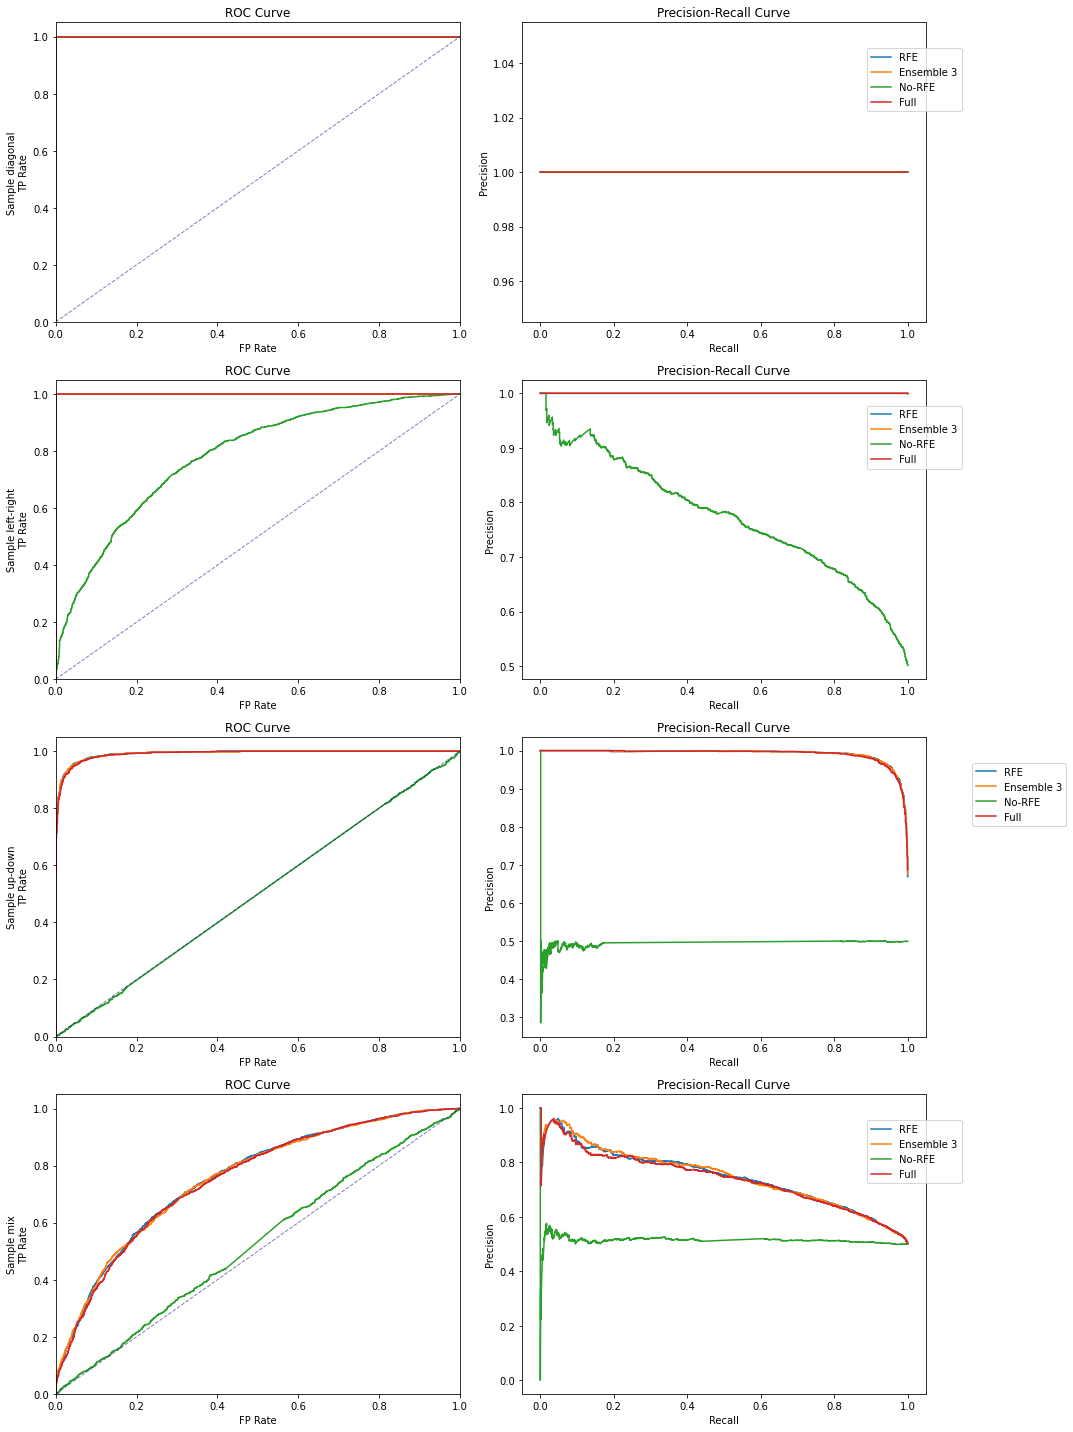

In [25]:
def roc(results, ax=None, labels=True, conf=None):
    if ax == None:
        ax = plt.gca()
        
    conf = conf or {}

    for res in results:
        cname = "{}".format(res.clf_name)
        label = res.clf_name if labels else "_no_legend_"
        ax.plot(res["fpr"], res["tpr"],  label=label, **conf)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title('ROC Curve')
    
    return ax


def prc(results, ax=None, labels=True, conf=None):
    if ax == None:
        ax = plt.gca()
        
    conf = conf or {}
    
    for r in results:
        label = r.clf_name if labels else "_no_legend_"
        ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label, **conf)
        
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    

labels = True
    
HNAMES = [
    ("RFE", "rfe", {}),
#     ("Ensemble 2", "rfe_e2", {}),
    ("Ensemble 3", "rfe_e3", {}),
#     ("Ensemble 4", "rfe_e4", {}),
#     ("Ensemble 6", "rfe_e6", {}),
    ("No-RFE", "nrfe", {}), 
    ("Full", "full", {"color": "k", "ls": "--"})
]

    
fig, axs = plt.subplots(4, 2, figsize=(15, 5*4))
axs = iter(axs)
for k, sr in buff.items():
    ax = next(axs)
    results = []
    for nn, dat, conf in HNAMES:
        
        dat = Container(sr[dat])
        dat.clf_name = nn
        results.append(dat)
        
    roc(results, ax=ax[0], labels=labels)
    prc(results, ax=ax[1], labels=labels)
    
    y_label = f"Sample {k}\n{ax[0].get_ylabel()}"
    
    ax[0].set_ylabel(y_label)

    lgd = ax[1].legend(bbox_to_anchor=(1.1, 0.93))
    fig.tight_layout();

fig.savefig("plots/rfe_curve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [24]:
!mkdir plots

In [43]:
s=df[["x0", "x1", "cls"]]

In [53]:
s.

x0     float64
x1     float64
cls      int64
dtype: object

In [57]:
print(s.to_())

ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.